In [1]:
%pip install ragas
%pip install matplotlib
%pip install torch
%pip install umap-learn
%pip install tiktoken
%pip install openai
%pip install umap-pytorch
%pip install -U pydantic
%pip install tsne-torch

  Using cached tiktoken-0.7.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
  Using cached pysbd-0.3.4-py3-none-any.whl.metadata (6.1 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached langchain_openai-0.1.17-py3-none-any.whl.metadata (2.5 kB)
  Using cached langchain_openai-0.1.16-py3-none-any.whl.metadata (2.5 kB)
  Using cached langchain_openai-0.1.15-py3-none-any.whl.metadata (2.5 kB)
  Using cached langchain_openai-0.1.14-py3-none-any.whl.metadata (2.5 kB)
  Using cached langchain_openai-0.1.13-py3-none-any.whl.metadata (2.5 kB)
INFO: pip is still looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached langchain_openai-0.1.12-py3-none-any.whl.metadata (2.5 kB)
  Using

In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices())

2024-08-20 13:20:58.213883: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 13:20:58.570627: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
import warnings

warnings.simplefilter("ignore")

import time

import torch

from tsne_based_rag import TSNE_Based_RAG_Util

from umap_based_rag import UMAP_Based_RAG_Util

from som_based_rag import SOM_Based_RAG_Util

from wiki_datasource import WikiEventsDataSource

from openai_vector_encoder import OpenAIEmbeddingsVectorEncoder

from openai_qa_chatbot import OpenAIQuestionAnswerChatBot

from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)

from ragas import evaluate

from datasets import Dataset , load_dataset

import pandas as pd

import os

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
openai_key  = "openai key here"

os.environ["OPENAI_API_KEY"] = openai_key

openai_vector_encoder_id = "text-embedding-ada-002"

openai_encoded_vector_dimensions = 1536

openai_tokenizer_name = "cl100k_base" 

openai_model_name = "gpt-3.5-turbo-instruct"

vector_encoder = OpenAIEmbeddingsVectorEncoder( openai_encoded_vector_dimensions, openai_vector_encoder_id, openai_key )

In [12]:
event_years_to_fetch = [ 2022, 2023, 2024 ]
data_source = WikiEventsDataSource( event_years_to_fetch  )

In [13]:
#init the algorithm utils
umap_driven_rag_util = UMAP_Based_RAG_Util( 
                                            vector_encoder = vector_encoder,
                                            n_neighbors = 5,
                                            min_dist = 0.1,
                                            n_components = 2,
                                            k_clusters = 100,
                                            metric = 'cosine',
                                            topk_bmu_for_indexing = 10,
                                            device = device
                                        )

In [14]:
som_driven_rag_util = SOM_Based_RAG_Util( 
                                            vector_encoder = vector_encoder,
                                            som_lattice_height = 20,
                                            som_lattice_width = 30,
                                            learning_rate = 0.3,
                                            topk_bmu_for_indexing = 5,
                                            device = device
                                        )

In [15]:
tsne_driven_rag_util = TSNE_Based_RAG_Util( 
                    vector_encoder = vector_encoder, 
                    n_components = 2,
                    k_clusters = 100,
                    epochs =  300, 
                    perplexity  = 30,
                    metric = 'cosine',
                    topk_bmu_for_indexing = 10,
                    vectorize_batch_size  = 100,
                    device = device
                                        )

In [16]:
#load & vectorize data
umap_driven_rag_util.load_n_vectorize_data( data_source )

Vectorized Data Batch:   0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
som_driven_rag_util.load_n_vectorize_data( data_source )

Vectorized Data Batch:   0%|          | 0/6 [00:00<?, ?it/s]

In [18]:
tsne_driven_rag_util.load_n_vectorize_data( data_source )

Vectorized Data Batch:   0%|          | 0/6 [00:00<?, ?it/s]

In [19]:
umap_driven_rag_util.vectors.shape
som_driven_rag_util.vectors.shape

torch.Size([529, 1536])

SOM-Based Indexed Vectors:   0%|          | 0/529 [00:00<?, ?it/s]

7.792618944000424


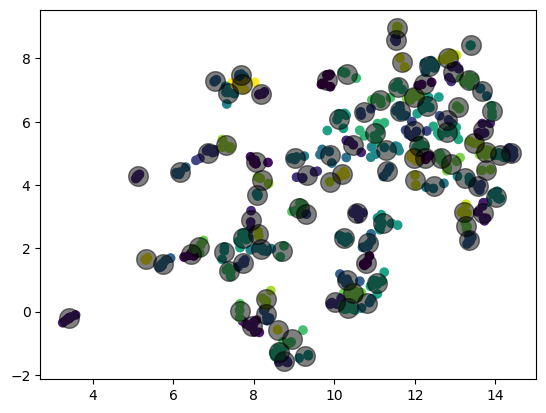

In [20]:
#train umap
umap_train_t1 = time.perf_counter()
umap_driven_rag_util.train_n_index_data_vectors()
umap_training_time = time.perf_counter() - umap_train_t1
print(umap_training_time)

In [21]:
#train som
som_train_t1 = time.perf_counter()
som_driven_rag_util.train_n_index_data_vectors()
som_training_time = time.perf_counter() - som_train_t1
print(som_training_time)

Kohonen's SOM Train Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

data points dimensions torch.Size([529, 1536])  lattice dimensions torch.Size([600, 1536])


SOM-Based Indexed Vectors:   0%|          | 0/529 [00:00<?, ?it/s]

13.22091430799992


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 529 samples in 0.001s...
[t-SNE] Computed neighbors for 529 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 529 / 529
[t-SNE] Mean sigma: 0.238179
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.409790
[t-SNE] KL divergence after 300 iterations: 1.141483


SOM-Based Indexed Vectors:   0%|          | 0/529 [00:00<?, ?it/s]

1.1226011420003488


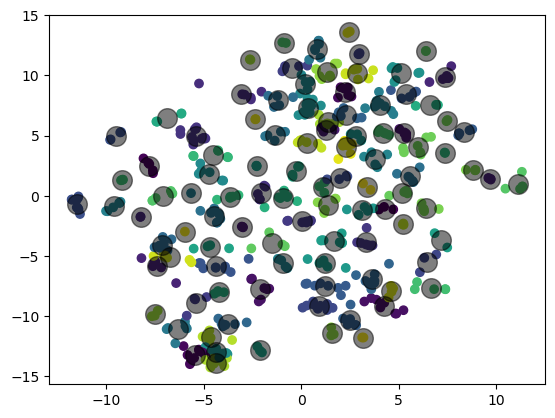

In [22]:
#train tsne
tsne_train_t1 = time.perf_counter()
tsne_driven_rag_util.train_n_index_data_vectors()
tsne_training_time = time.perf_counter() - tsne_train_t1
print(tsne_training_time)

In [23]:
#quick test to make sure we are fetching context
umap_driven_rag_util.find_semantically_similar_data( "Who won the 2024 Sri Lankan Presidential Election?", sim_threshold = 0.55 )

[{'text': 'September 21, 2024 – 2024 Sri Lankan presidential election.',
  'sim_score': 0.731831967830658},
 {'text': 'July 21, 2022 – The Parliament of Sri Lanka elects Prime Minister Ranil Wickremesinghe as President of Sri Lanka, following the resignation of Gotabaya Rajapaksa amid protests over the ongoing economic crisis.',
  'sim_score': 0.5689175724983215}]

In [24]:
som_driven_rag_util.find_semantically_similar_data( "Who won the 2024 Sri Lankan Presidential Election?", sim_threshold = 0.55 )

[{'text': 'September 21, 2024 – 2024 Sri Lankan presidential election.',
  'sim_score': 0.7317341566085815}]

In [25]:
#init the chatbots
umap_openai_chatbot = OpenAIQuestionAnswerChatBot( 
                                                vector_db_util = umap_driven_rag_util,
                                                openai_tokenizer_name = openai_tokenizer_name,
                                                openai_model_name = openai_model_name,
                                                openai_key = openai_key,
                                                question_input_max_token_count = 100,
                                                context_trim_percent = 0.1,
                                                device = device
                                            )

In [26]:
som_openai_chatbot = OpenAIQuestionAnswerChatBot( 
                                                vector_db_util = som_driven_rag_util,
                                                openai_tokenizer_name = openai_tokenizer_name,
                                                openai_model_name = openai_model_name,
                                                openai_key = openai_key,
                                                question_input_max_token_count = 100,
                                                context_trim_percent = 0.1,
                                                device = device
                                            )


In [27]:
tsne_openai_chatbot = OpenAIQuestionAnswerChatBot( 
                                                vector_db_util = tsne_driven_rag_util,
                                                openai_tokenizer_name = openai_tokenizer_name,
                                                openai_model_name = openai_model_name,
                                                openai_key = openai_key,
                                                question_input_max_token_count = 100,
                                                context_trim_percent = 0.1,
                                                device = device
                                            )

In [28]:
sample_questions =    ["Who won the 2024 Sri Lankan Presidential Election?",
                    "Who won the 2022 soccer world cup?",
                        "When did Sweden join NATO?",
                        "Who joined NATO in 2023?", 
                        "Who joined NATO in 2024?", 
                        "Which is the 31st member of NATO?", 
                        "Which is the 32nd member of NATO?", 
                        "Who won the Cricket World Cup in 2023?", 
                        "Who defeated India in Cricket World Cup final in 2023?", 
                        "Name the former prime minister of Japan that was assassinated in 2022?", 
                        "When did Chandrayaan-3 land near the south pole of the Moon?", 
                        "Where did Chandrayaan-3 land on the Moon?",
                        "Who acquired Twitter in 2022?", 
                        "Who owns Twitter?",
                        "Who acquired Activision Blizzard in 2023?", 
                        "What country was invaded by Russia in 2022?", 
                        "What year did Russia invade Ukraine?" ]
                   
sample_answers =    ["The winner of the 2024 Sri Lankan Presidential Election was Ranil Wickremesinghe",
                       "The winner of the 2022 Soccer World Cup was Argentina",
                      "Sweden joined NATO in 2024",
                     "Finland joined NATO in 2023",
                        "Sweden joined NATO in 2024",
                        "Finland joined NATO in 2023, becoming the 31st member state.",
                       "Sweden joined NATO in 2023, becoming the 32nd member state.",
                       "Australia won the 2023 cricket world cup",
                        "Australia defeated India in the 2023 cricket world cup.",
                        "Former Prime Minister of Japan, Shinzo Abe, was assasinated in 2022.",
                      "On July 14, 2023, India successfully landed lunar prove Chandrayaan-3 near the moon's south pole",
                       "On July 14, 2023, India successfully landed lunar prove Chandrayaan-3 near the moon's south pole",
                         "Elon Musk aquired social media platform twitter in 2022 for 44 billion dollars",
                         "Elon Musk has owned twitter since he aquired the platform for 44 billion usd in 2022",
                         "Microsoft aquired activision blizzard in 2023",
                      "Ukraine was invaded by Russia in 2022",
                        "Russia invaded Ukraine in 2022"]

In [29]:
#dictionaries to be turned into datasets for the ragas frameworks
dataset_dict_umap = {
    "question" : sample_questions,
    "ground_truth" :  sample_answers,
    "answer" : [""] * 17,
    "contexts" : [[""]]*17
}

dataset_dict_som = {
    "question" : sample_questions,
    "ground_truth" :  sample_answers,
    "answer" : [""] * 17,
    "contexts" : [[""]]*17
}

dataset_dict_tsne = {
    "question" : sample_questions,
    "ground_truth" :  sample_answers,
    "answer" : [""] * 17,
    "contexts" : [[""]]*17
}


In [30]:
#answering questions with no context
for sample_question in sample_questions:
    print( f"\nQuestion: {sample_question}" )
    answer = umap_openai_chatbot.find_answer_to_question_without_context( sample_question )
    print( f"Answer: {answer}" )



Question: Who won the 2024 Sri Lankan Presidential Election?
Answer: As of now, it is not possible to determine the outcome of the 202

Question: Who won the 2022 soccer world cup?
Answer: The 2022 soccer world cup has not yet taken place, so the winner

Question: When did Sweden join NATO?
Answer: Sweden never joined NATO.

Question: Who joined NATO in 2023?
Answer: I'm sorry, I cannot answer this question as I am a pre-trained AI

Question: Who joined NATO in 2024?
Answer: Nobody knows for sure who will join NATO in 2024. It could be

Question: Which is the 31st member of NATO?
Answer: Albania.

Question: Which is the 32nd member of NATO?
Answer: There is no single "32nd member" of NATO, as the organization

Question: Who won the Cricket World Cup in 2023?
Answer: The 2023 Cricket World Cup has not yet taken place, so it

Question: Who defeated India in Cricket World Cup final in 2023?
Answer: It is not possible to answer this question as it has not happened yet. The

Question: Name

In [31]:
sim_threshold = 0.55
for i in range(0, len(sample_questions)):
    print( f"\nQuestion: {sample_questions[i]}" )
    answer = umap_openai_chatbot.find_answer_to_question( sample_questions[i], sim_threshold = sim_threshold, data_dict = dataset_dict_umap, data_dict_index = i )
    print( f"Answer: {answer}" )


Question: Who won the 2024 Sri Lankan Presidential Election?
Answer: Prime Minister Ranil Wickremesinghe was elected as President of Sri Lanka

Question: Who won the 2022 soccer world cup?
Answer: Argentina won the 2022 FIFA World Cup.

Question: When did Sweden join NATO?
Answer: March 7, 2024.

Question: Who joined NATO in 2023?
Answer: Finland.

Question: Who joined NATO in 2024?
Answer: Sweden.

Question: Which is the 31st member of NATO?
Answer: Finland.

Question: Which is the 32nd member of NATO?
Answer: Sweden

Question: Who won the Cricket World Cup in 2023?
Answer: Australia.

Question: Who defeated India in Cricket World Cup final in 2023?
Answer: Australia

Question: Name the former prime minister of Japan that was assassinated in 2022?
Answer: Shinzo Abe

Question: When did Chandrayaan-3 land near the south pole of the Moon?
Answer: August 23, 2023

Question: Where did Chandrayaan-3 land on the Moon?
Answer: Near the south pole of the Moon.

Question: Who acquired Twitter

In [32]:
dataset_umap = Dataset.from_dict(dataset_dict_umap)

print(type(dataset_umap['contexts']))
result =evaluate(
    dataset_umap,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
    ], 
)

result.to_pandas().head()

<class 'list'>


Evaluating:   0%|          | 0/68 [00:00<?, ?it/s]

No statements were generated from the answer.


,question,ground_truth,answer,contexts,context_precision,faithfulness,answer_relevancy,context_recall
0,Who won the 2024 Sri Lankan Presidential Elect...,The winner of the 2024 Sri Lankan Presidential...,Prime Minister Ranil Wickremesinghe was electe...,"[September 21, 2024 – 2024 Sri Lankan presiden...",0.0,1.0,0.930572,0.0
1,Who won the 2022 soccer world cup?,The winner of the 2022 Soccer World Cup was Ar...,Argentina won the 2022 FIFA World Cup.,"[December 18, 2022 – Argentina wins the 2022 F...",1.0,1.0,0.984046,1.0
2,When did Sweden join NATO?,Sweden joined NATO in 2024,"March 7, 2024.","[March 7, 2024 – As the final Nordic country t...",1.0,1.0,0.989357,1.0
3,Who joined NATO in 2023?,Finland joined NATO in 2023,Finland.,"[April 4, 2023 – Finland becomes the 31st memb...",1.0,1.0,0.894772,1.0
4,Who joined NATO in 2024?,Sweden joined NATO in 2024,Sweden.,"[April 4, 2023 – Finland becomes the 31st memb...",0.5,1.0,0.883034,1.0


In [33]:

for i in range(0, len(sample_questions)):
    print( f"\nQuestion: {sample_questions[i]}" )
    answer = som_openai_chatbot.find_answer_to_question( sample_questions[i], sim_threshold = sim_threshold, data_dict = dataset_dict_som, data_dict_index = i )
    print( f"Answer: {answer}" )



Question: Who won the 2024 Sri Lankan Presidential Election?
Answer: As of now, it is impossible to say for certain. However, some of

Question: Who won the 2022 soccer world cup?
Answer: Argentina won the 2022 soccer world cup.

Question: When did Sweden join NATO?
Answer: March 7, 2024

Question: Who joined NATO in 2023?
Answer: Finland.

Question: Who joined NATO in 2024?
Answer: Sweden.

Question: Which is the 31st member of NATO?
Answer: Finland

Question: Which is the 32nd member of NATO?
Answer: Sweden

Question: Who won the Cricket World Cup in 2023?
Answer: Australia

Question: Who defeated India in Cricket World Cup final in 2023?
Answer: Australia

Question: Name the former prime minister of Japan that was assassinated in 2022?
Answer: Shinzo Abe

Question: When did Chandrayaan-3 land near the south pole of the Moon?
Answer: Chandrayaan-3 landed near the south pole of the Moon on August

Question: Where did Chandrayaan-3 land on the Moon?
Answer: Near the south pole of the 

In [34]:
dataset_som = Dataset.from_dict(dataset_dict_som)

result =evaluate(
    dataset_som,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
    ], 
)

result.to_pandas().head()



Evaluating:   0%|          | 0/68 [00:00<?, ?it/s]

,question,ground_truth,answer,contexts,context_precision,faithfulness,answer_relevancy,context_recall
0,Who won the 2024 Sri Lankan Presidential Elect...,The winner of the 2024 Sri Lankan Presidential...,"As of now, it is impossible to say for certain...","[September 21, 2024 – 2024 Sri Lankan presiden...",0.0,1.0,0.000000,0.0
1,Who won the 2022 soccer world cup?,The winner of the 2022 Soccer World Cup was Ar...,Argentina won the 2022 soccer world cup.,"[December 18, 2022 – Argentina wins the 2022 F...",1.0,1.0,0.984072,1.0
2,When did Sweden join NATO?,Sweden joined NATO in 2024,"March 7, 2024","[March 7, 2024 – As the final Nordic country t...",1.0,1.0,0.989420,1.0
3,Who joined NATO in 2023?,Finland joined NATO in 2023,Finland.,"[April 4, 2023 – Finland becomes the 31st memb...",1.0,1.0,0.930226,1.0
4,Who joined NATO in 2024?,Sweden joined NATO in 2024,Sweden.,"[April 4, 2023 – Finland becomes the 31st memb...",0.5,1.0,0.883027,1.0


In [35]:

for i in range(0, len(sample_questions)):
    print( f"\nQuestion: {sample_questions[i]}" )
    answer = tsne_openai_chatbot.find_answer_to_question( sample_questions[i], sim_threshold = sim_threshold, data_dict = dataset_dict_tsne, data_dict_index = i )
    print( f"Answer: {answer}" )


Question: Who won the 2024 Sri Lankan Presidential Election?
Answer: Ranil Wickremesinghe won the 2024 Sri Lankan Presidential

Question: Who won the 2022 soccer world cup?
Answer: Argentina.

Question: When did Sweden join NATO?
Answer: March 7, 2024

Question: Who joined NATO in 2023?
Answer: Finland

Question: Who joined NATO in 2024?
Answer: Sweden became the 32nd member of NATO in 2024, following Finland

Question: Which is the 31st member of NATO?
Answer: Finland

Question: Which is the 32nd member of NATO?
Answer: Sweden

Question: Who won the Cricket World Cup in 2023?
Answer: Australia won the Cricket World Cup in 2023.

Question: Who defeated India in Cricket World Cup final in 2023?
Answer: Australia

Question: Name the former prime minister of Japan that was assassinated in 2022?
Answer: Shinzo Abe

Question: When did Chandrayaan-3 land near the south pole of the Moon?
Answer: August 23, 2023

Question: Where did Chandrayaan-3 land on the Moon?
Answer: Near the south pole 

In [36]:
dataset_tsne = Dataset.from_dict(dataset_dict_tsne)

result =evaluate(
    dataset_tsne,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
    ], 
)

result.to_pandas().head()


Evaluating:   0%|          | 0/68 [00:00<?, ?it/s]

,question,ground_truth,answer,contexts,context_precision,faithfulness,answer_relevancy,context_recall
0,Who won the 2024 Sri Lankan Presidential Elect...,The winner of the 2024 Sri Lankan Presidential...,Ranil Wickremesinghe won the 2024 Sri Lankan P...,"[September 21, 2024 – 2024 Sri Lankan presiden...",0.0,0.0,0.998467,0.0
1,Who won the 2022 soccer world cup?,The winner of the 2022 Soccer World Cup was Ar...,Argentina.,"[December 18, 2022 – Argentina wins the 2022 F...",1.0,1.0,0.963889,1.0
2,When did Sweden join NATO?,Sweden joined NATO in 2024,"March 7, 2024","[March 7, 2024 – As the final Nordic country t...",1.0,1.0,0.989420,1.0
3,Who joined NATO in 2023?,Finland joined NATO in 2023,Finland,"[April 4, 2023 – Finland becomes the 31st memb...",1.0,1.0,0.894772,1.0
4,Who joined NATO in 2024?,Sweden joined NATO in 2024,"Sweden became the 32nd member of NATO in 2024,...","[April 4, 2023 – Finland becomes the 31st memb...",0.5,1.0,0.859374,1.0


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1894, in _run_once
    handle = self._ready.popleft()
IndexError: pop from 